In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
%matplotlib inline
plt.style.use('ggplot')

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:31:59.624480. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [3]:
from fact.io import read_h5py
from fact.analysis import li_ma_significance, split_on_off_source_independent

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:32:11.279349. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [4]:
feature = ['conc_core',
           'concentration_one_pixel',    
           'concentration_two_pixel',
           'leakage', 
           'leakage2', 
           'size', 
           'width', 
           'num_islands', 
           'num_pixel_in_shower', 
           'ph_charge_shower_max',
           'ph_charge_shower_mean',
           'ph_charge_shower_min',
           'ph_charge_shower_variance']

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:32:26.934288. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [5]:
gamma = pd.read_hdf(
    '/home/msackel/Desktop/gammaClassification/data/raw_data/gamma_precuts.hdf5',
    key='events'
)

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:33:13.691925. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [6]:
hadron_data = read_h5py(
    '/home/msackel/Desktop/gammaClassification/Markarian/mrk501_2014_precuts.hdf5',
    key='events',
    columns=list(feature) + [
        'theta_deg',
        'theta_deg_off_1',
        'theta_deg_off_2',
        'theta_deg_off_3',
        'theta_deg_off_4',
        'theta_deg_off_5',
    ]
)

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:33:58.909964. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [7]:
hadron = hadron_data[hadron_data['theta_deg']**2 >= 0.25]
hadron['label'] = 0
gamma['label'] = 1

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:34:15.371888. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)
/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [8]:
Testset = pd.concat([hadron[feature + ['label', 'theta_deg']][:len(gamma)], gamma[feature + ['label', 'theta_deg']][:len(gamma)]])

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:34:35.377406. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [19]:
dataSimu = pd.read_pickle('/home/msackel/Desktop/gammaClassification/data/complete_Datasets/dataSimu')

In [9]:
parameters1 = {
    'max_depth': 1,
    'learning_rate':0.5,
    'n_estimators':100,
    'booster': 'gbtree', 
    'gamma':0.5,
    'n_jobs': 25,
    'reg_lambda': 0.1,
    'subsample': 0.20,
    'eval_metric': 'auc'
}
xgbc1 = XGBClassifier(**parameters1)

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-13 13:35:02.623609. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [27]:
xgbc1.fit(Testset.drop(['label', 'theta_deg'], axis=1), Testset['label'])
#xgbc1.fit(dataSimu.drop('label', axis=1), dataSimu['label'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0.5, learning_rate=0.5,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=25, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=0.1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.2)

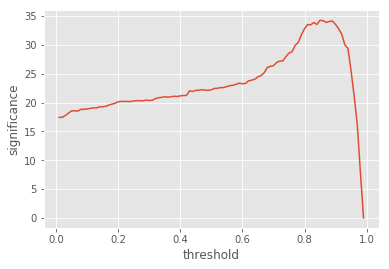

In [28]:
hadron_data['gamma_prediction'] = xgbc1.predict_proba(hadron_data[feature])[:, 1]
significance = []
for threshold in np.linspace(0.01, 0.99, 99):
    on_data, off_data = split_on_off_source_independent(hadron_data.query('gamma_prediction >'+threshold.astype(str)), theta2_cut=0.03)
    significance.append(li_ma_significance(len(on_data), len(off_data), 0.2))
plt.plot(np.linspace(0.01, 0.99, 99), significance)
plt.xlabel('threshold')
plt.ylabel('significance');

In [29]:
max(significance)

34.272998441828577

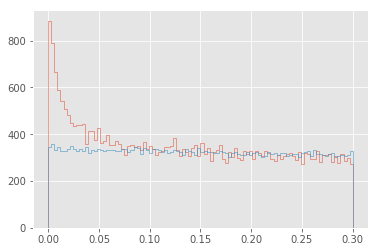

In [30]:
selected = hadron_data.query('gamma_prediction >= 0.84')
theta_on = selected.theta_deg
theta_off = pd.concat([selected['theta_deg_off_' + str(i)] for i in range(1, 6)])
plt.hist(theta_on**2, range=[0, 0.3], bins=100, histtype='step', label='On')
plt.hist(theta_off**2, range=[0, 0.3], bins=100, histtype='step', label='Off', weights=np.full(len(theta_off),  0.2))
None

# Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

Tree = RandomForestClassifier(max_depth=15, max_features=7 ,criterion='entropy', n_estimators=100, n_jobs=15)
#Tree.fit(Testset.drop(['label', 'theta_deg'], axis=1), Testset['label'])
Tree.fit(dataSimu.drop('label', axis=1), dataSimu['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features=7, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=15, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [24]:
hadron_data['gamma_prediction'] =Tree.predict_proba(hadron_data[feature])[:, 1]

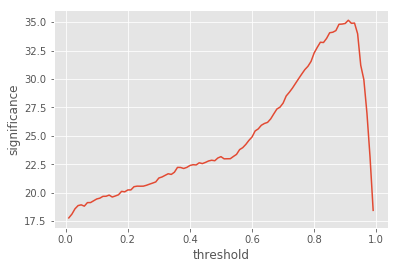

In [25]:
significance = []
for threshold in np.linspace(0.01, 0.99, 99):
    on_data, off_data = split_on_off_source_independent(hadron_data.query('gamma_prediction >'+threshold.astype(str)), theta2_cut=0.03)
    significance.append(li_ma_significance(len(on_data), len(off_data), 0.2))
plt.plot(np.linspace(0.01, 0.99, 99 ), significance)
plt.xlabel('threshold')
plt.ylabel('significance');

In [26]:
max(significance)

35.165948252369745